# Grupo de Estudos de Aprendizado de Máquina (GEAM)
### Hotspot Mapping: identificando locais de risco para a ocorrência de crimes

## Sobre o problema
 - ### **Contexto**
    > #### Imagine que você foi encarregado para decidir quais áreas da região de Manhattan devem receber mais patrulhamento policial. 
   > **Como você resolveria esse problema?**

 - ### **Informações**
   - Conjunto de dados com registros de crimes de toda a cidade de NY
   - A força policial disponível é capaz de cobrir apenas 5% da região
 
 - ### **Objetivo**
  - Identificar áreas de risco na região de **Manhattan**
  - Determinar o nome das ruas da cidade que deverão receber reforço no patrulhamento policial

# Conjunto de dados

> [New York City Crimes](
https://www.kaggle.com/datasets/adamschroeder/crimes-new-york-city?resource=download)

 - Crimes reportados em todos os 5 bairros da cidade de NY (2014-2015)
 - Subconjunto dos dados disponíveis em [NYPD Complaint Data Historic, 2006 - 2019](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i)

 

## Setup

In [1]:
# Instalação de dependências

!pip install geopandas osmnx contextily matplotlib==3.1.3 --quiet

In [2]:
# Importando scripts do drive

# Observação: para executar na máquina local, basta manter a pasta scripts no mesmo diretório 
# deste notebook e ignorar esse passo

MY_DRIVE_MOUNT_POINT_PATH = '/content/MyDrive'
MY_DRIVE_SCRIPTS_PATH = '/content/MyDrive/MyDrive/GEAM'

import sys
from google.colab import drive
drive.mount(MY_DRIVE_MOUNT_POINT_PATH)
sys.path.append(MY_DRIVE_SCRIPTS_PATH)

In [3]:
import pandas as pd
import geopandas as gpd
import contextily as cx
from shapely.geometry import box
import osmnx as ox

from scripts.hotspot import Hotspot
from scripts.tessellation import GridTessellationTiler
from scripts.estimator import  KernelDensity

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 12)

# Carregando dados

In [4]:
# Criando o dataframe com os dados dos crimes

CRIMES_CSV_PATH = './data/NYPD_Complaint_Data_Historic.csv'

crimes_df = pd.read_csv(CRIMES_CSV_PATH)

crimes_df.head()

/tmp/ipykernel_123963/4191595208.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes_df = pd.read_csv(CRIMES_CSV_PATH)


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,44.0,INSIDE,BAR/NIGHT CLUB,NaN,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)"
1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,NaN,...,103.0,OUTSIDE,NaN,NaN,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)"
2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,"CONTROLLED SUBSTANCE,INTENT TO",...,28.0,NaN,OTHER,NaN,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)"
3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,105.0,INSIDE,RESIDENCE-HOUSE,NaN,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)"
4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,13.0,FRONT OF,OTHER,NaN,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)"


In [5]:
# Definindo as projeções utilizadas

DEGREE_CRS = 'EPSG:4326'  # https://epsg.io/4326
METRIC_CRS = 'EPSG:32115' # https://epsg.io/32115

In [6]:
# Convertendo o dataframe de crimes em um geodataframe

important_columns = ['BORO_NM']

crimes_gdf = gpd.GeoDataFrame(crimes_df[important_columns], geometry=gpd.points_from_xy(crimes_df.Longitude, crimes_df.Latitude), crs=DEGREE_CRS).to_crs(METRIC_CRS)

crimes_gdf.head()

,BORO_NM,geometry
0,BRONX,POINT (199201.264 221706.443)
1,QUEENS,POINT (210462.649 207186.185)
2,MANHATTAN,POINT (196825.103 218777.010)
3,QUEENS,POINT (215424.553 202476.702)
4,MANHATTAN,POINT (193252.282 211581.426)


# Visualização dos dados

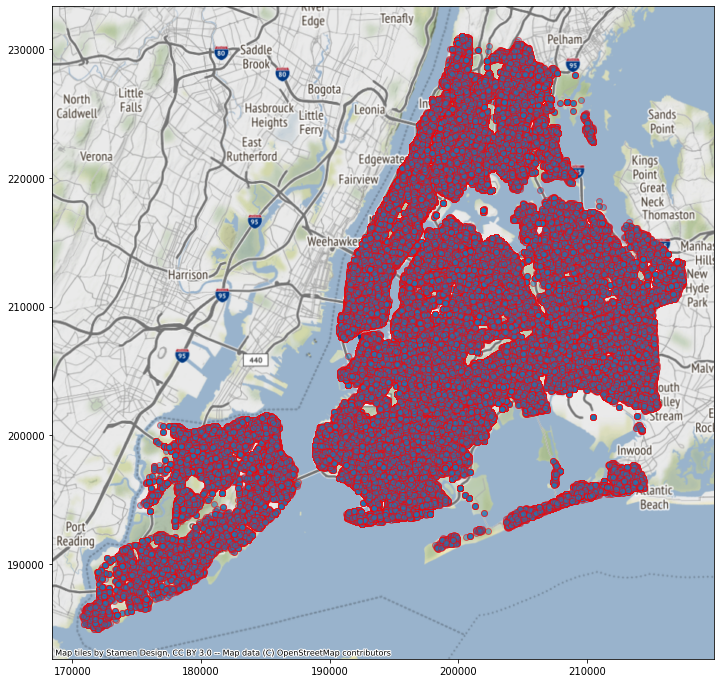

In [7]:
ax = crimes_gdf.plot(alpha=0.5, edgecolor='r')

cx.add_basemap(ax, crs=crimes_gdf.crs)

# Isolando a região de Manhattan

In [8]:
# Carregando o geodataframe da cidade de NY

ny_gdf = gpd.read_file(gpd.datasets.get_path('nybb')).to_crs(METRIC_CRS)
ny_gdf.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((188061.075 192500.760, 188064...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((206143.151 195782.371, 206134...."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((203582.140 194335.664, 203529...."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((191339.660 205628.594, 191255...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((200900.945 218049.027, 200890...."


In [9]:
# Isolando apenas a geometria de Manhattan 

manhattan_gdf = ny_gdf[ny_gdf['BoroName'] == 'Manhattan']
crimes_manhattan = crimes_gdf[crimes_gdf['BORO_NM'] == 'MANHATTAN'] 

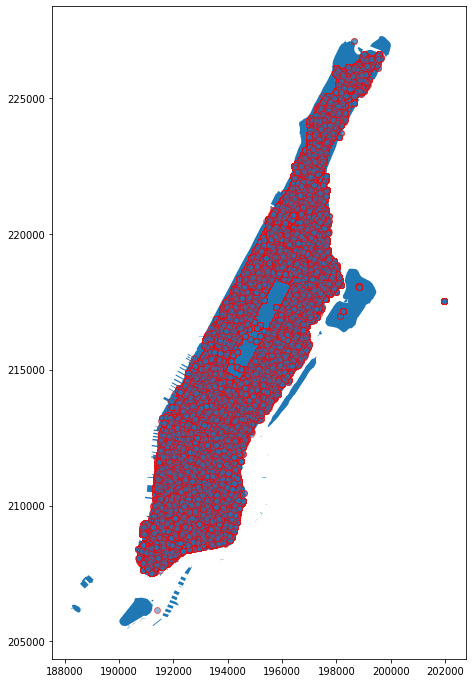

In [10]:
# Visualização

ax = manhattan_gdf.plot()
crimes_manhattan.plot(ax=ax, alpha=0.5, edgecolor='r')

In [11]:
# Removendo os pontos que estão fora do bairro

[_, indexes] = crimes_manhattan.sindex.query_bulk(manhattan_gdf.geometry, predicate="contains")
crimes_within_manhattan = crimes_manhattan.iloc[indexes].copy()

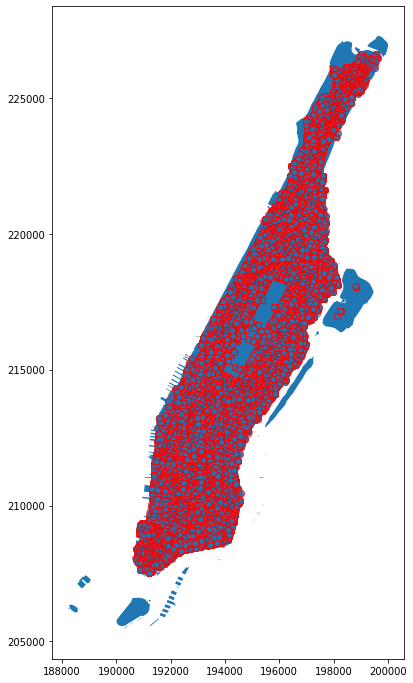

In [12]:
# Visualização

ax = manhattan_gdf.plot()
crimes_within_manhattan.plot(ax=ax, alpha=0.5, edgecolor='r')

# Criação da grade de células

In [13]:
# Criando uma grade de células com 100m de área em cada célula

grid = GridTessellationTiler(cell_size=100, geometry=manhattan_gdf.geometry.iloc[0])

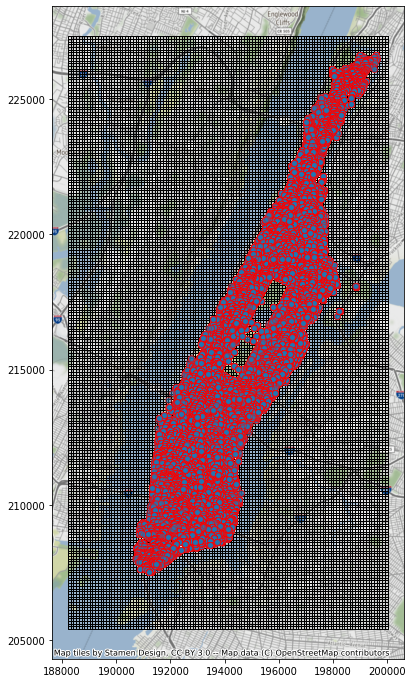

In [14]:
# Visualização dos crimes em manhattan juntamente com a grade de células

ax = grid.geodataframe.plot(facecolor='none', alpha=1)
ax = crimes_within_manhattan.plot(ax=ax, alpha=0.5, edgecolor='r')
cx.add_basemap(ax, crs=manhattan_gdf.crs)

# Utilizando o KDE

In [15]:
# Obtendo densidades com o KDE
# - Calcula a distância euclidiana de cada evento para cada célula do grid
# - Aplica a função de kernel (em eventos com distância menor que o bandwidth)
# - Soma as densidades de todos os eventos em cada célula

kde = KernelDensity(bandwidth=400, method='kdtree', kernel='quartic')
kde.fit(grid)
kde.score(crimes_within_manhattan)

array([0., 0., 0., ..., 0., 0., 0.])

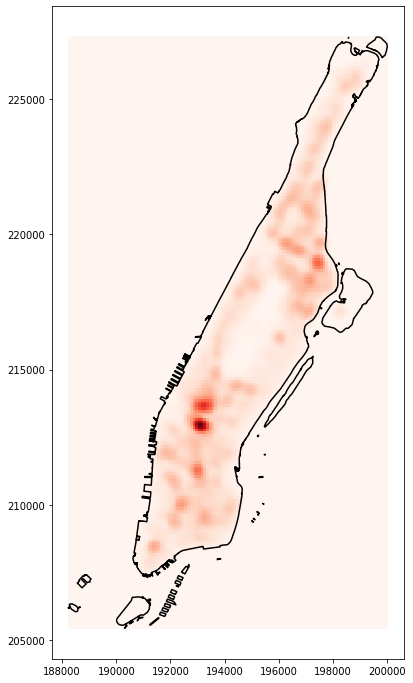

In [16]:
# Visualização da densidade gerada pelo KDE

grid.geodataframe['density'] = kde._score_value

ax = manhattan_gdf.boundary.plot(color='black')
grid.geodataframe.plot(ax=ax, column='density', cmap='Reds')

# Gerando Hotspots

In [17]:
# Gerando os hotspots usando os scores obtidos com o kde
# - seleciona como hotspot as celulas que tiveram as maiores densidades
# - a seleção para quando a soma da área das células chegar a 5% da área total

AREA_COVERAGE_BY_PATROL=0.05 # 5%

hotspot_instance = Hotspot(percentage=AREA_COVERAGE_BY_PATROL, crs=crimes_manhattan.crs)

hotspot_instance.fit(grid, kde._score_value)

,geometry,density
8898,"POLYGON ((193118.073 213015.627, 193118.073 21...",0.000059
8899,"POLYGON ((193218.073 213015.627, 193218.073 21...",0.000058
8781,"POLYGON ((193218.073 212915.627, 193218.073 21...",0.000056
8780,"POLYGON ((193118.073 212915.627, 193118.073 21...",0.000054
9016,"POLYGON ((193118.073 213115.627, 193118.073 21...",0.000052
...,...,...
5007,"POLYGON ((193418.073 209715.627, 193418.073 20...",0.000015
7244,"POLYGON ((192918.073 211615.627, 192918.073 21...",0.000015
10435,"POLYGON ((193418.073 214315.627, 193418.073 21...",0.000015
9130,"POLYGON ((192718.073 213215.627, 192718.073 21...",0.000015


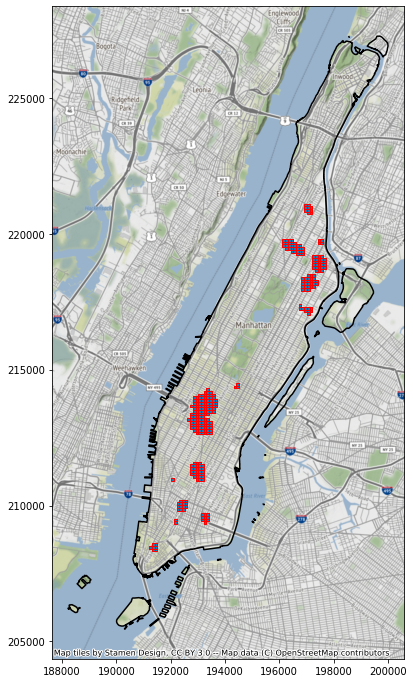

In [18]:
# Visualização dos Hotspots

ax = manhattan_gdf.boundary.plot(color='black')
ax = hotspot_instance.hotspots.plot(ax = ax, edgecolor='r')
cx.add_basemap(ax, crs=manhattan_gdf.crs)

# Encontrando as ruas da cidade de Manhattan



In [19]:
# Carregando grafo das ruas usando o osmnx (Geocoding)

manhattan_streets_graph = ox.graph_from_place('Manhattan, New York, USA')

/home/hernany/.local/lib/python3.8/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [20]:
# Convertendo o grafo de ruas em um geodataframe

manhattan_streets_gdf = ox.graph_to_gdfs(manhattan_streets_graph, nodes=False).to_crs(METRIC_CRS)
manhattan_streets_gdf.head()

osmid    highway  oneway   length  \
u        v          key                                          
30807314 4332491202 0    147089927       path   False   12.695   
         2057103273 0     46613689  bridleway   False  159.255   
         6579409036 0     46613689  bridleway   False   58.144   
         1203806263 0    147089927       path   False   28.607   
30978747 42442164   0    429504381   cycleway   False   19.687   

                                                                  geometry  \
u        v          key                                                      
30807314 4332491202 0    LINESTRING (195270.121 217447.442, 195261.481 ...   
         2057103273 0    LINESTRING (195270.121 217447.442, 195268.005 ...   
         6579409036 0    LINESTRING (195270.121 217447.442, 195272.825 ...   
         1203806263 0    LINESTRING (195270.121 217447.442, 195274.428 ...   
30978747 42442164   0    LINESTRING (194449.938 215615.386, 194430.360 ...   

                                          name maxspeed lanes  ref service  \
u        v          key                                                      
30807314 4332491202 0                      NaN      NaN   NaN  NaN     NaN   
         2057103273 0                      NaN      NaN   NaN  NaN     NaN   
         6579409036 0                      NaN      NaN   NaN  NaN     NaN   
         1203806263 0                      NaN      NaN   NaN  NaN     NaN   
30978747 42442164   0    Central Park Driveway      NaN   NaN  NaN     NaN   

                        access bridge tunnel width junction est_width area  
u        v          key                                                     
30807314 4332491202 0      NaN    NaN    NaN   NaN      NaN       NaN  NaN  
         2057103273 0      NaN    NaN    NaN   NaN      NaN       NaN  NaN  
         6579409036 0      NaN    NaN    NaN   NaN      NaN       NaN  NaN  
         1203806263 0      NaN    NaN    NaN   NaN      NaN       NaN  NaN  
30978747 42442164   0      NaN    NaN    NaN   NaN      NaN       NaN  NaN

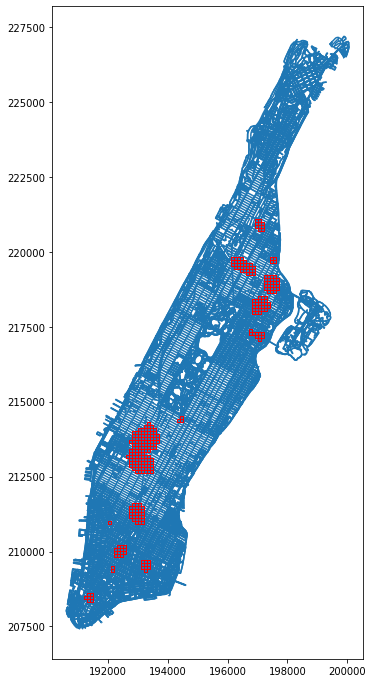

In [21]:
# Visualização dos hotspots sobrepostos na rede de ruas

ax = manhattan_streets_gdf.plot(zorder=1)
hotspot_instance.hotspots.plot(ax=ax, edgecolor='r', zorder=2)

# Capturando as ruas que tem intersecção com os hotspots

In [22]:
[_, indexes] = manhattan_streets_gdf.sindex.query_bulk(hotspot_instance.hotspots.geometry, predicate="intersects")

manhattan_streets_intersects_hotspot = manhattan_streets_gdf.iloc[indexes].copy()

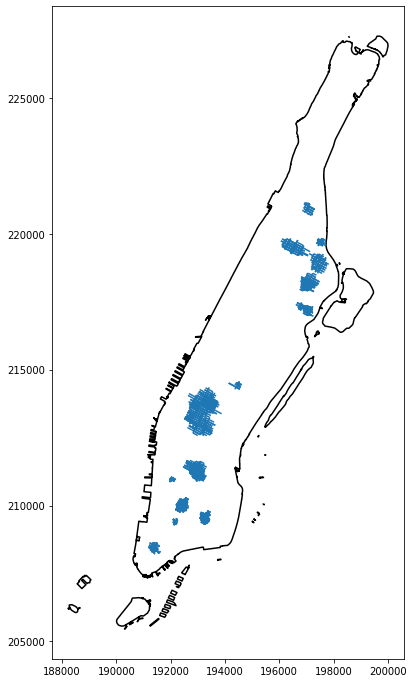

In [23]:
# Visualização das ruas que estão na localização indicadas pelos hotspots

ax=manhattan_gdf.boundary.plot(color='black')
manhattan_streets_intersects_hotspot.plot(ax=ax)

In [24]:
# Obtendo o nome das ruas, sem repetições e ignorando as ruas que não tem nome

street_names = manhattan_streets_intersects_hotspot.name.dropna().drop_duplicates().values

In [25]:
# Quantidade total de ruas encontradas

street_names.shape[0]

155

In [26]:
street_names

array(['West 33rd Street', 'West 34th Street', 'West 35th Street',
       '6th Avenue', 'West 32nd Street', '7th Avenue', 'West 36th Street',
       'Broadway', list(['6th Avenue', 'West 35th Street']),
       'West 31st Street', 'West 42nd Street', 'West 43rd Street',
       'West 44th Street', 'Shubert Alley', '8th Avenue',
       'West 41st Street', 'Pennsylvania Plaza',
       list(['Pennsylvania Plaza', 'West 33rd Street']),
       'West 45th Street', 'West 37th Street', 'West 40th Street',
       'East 125th Street', 'Lexington Avenue', 'East 123rd Street',
       'East 124th Street', 'West 46th Street', 'Park Avenue',
       'West 39th Street', 'East 14th Street', 'Union Square West',
       'Union Square East', 'University Place', 'East 126th Street',
       'East 15th Street', '4th Avenue', 'East 16th Street', '3rd Avenue',
       'East 13th Street', 'East 122nd Street', 'East 127th Street',
       'West 30th Street', 'West 38th Street', 'East 17th Street',
       'West 47th S

# Recapitulando

## Vimos sobre
  - [x] Operações com dados geoespaciais usando GeoPandas
  - [x] Tipos de Sistemas de projeção de coordenadas 
  - [x] Visualização dos dados usando contextily e matplotlib
  - [x] Geocoding e obtenção de dados do openstreetmap usando OSMNX
  - [x] Aplicação do KDE com grade de células para a geração de Hotspots

## Referências
 - [DOC] [Geopandas](https://geopandas.org/en/stable/docs.html)
 - [DOC] [OSMNX](https://osmnx.readthedocs.io/en/stable/)
 - [PAPER] [The Utility of Hotspot Mapping for Predicting Spatial Patterns of Crime](https://link.springer.com/article/10.1057/palgrave.sj.8350066)
 - [SITE] [Kernel Density Estimation](https://mathisonian.github.io/kde/)

## Tem uma dúvida? Pode entrar em contato :)
> Email: hernanytec777@gmail.com